In [32]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import deque
import datetime as dt
from statistics import mean

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

!pip install scikit-optimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize


     |████████████████████████████████| 106 kB 18.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 100 kB 14.1 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
nhl_odds = pd.read_csv('combined_nhl.csv')
nhl_stats = pd.read_csv('nst_2008_2021.csv')

nhl_odds

,Date,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,OpenOOdds,...,HomeTeam,Home1st,Home2nd,Home3rd,HomeFinal,MlHomeOpen,MlHomeClose,OpenUOdds,CloseUOdds,RealDate
0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,100,...,LosAngeles,1.0,1.0,2.0,4.0,135.0,103.0,-120.0,-115.0,2007-09-29
1,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,-115,...,Anaheim,2.0,2.0,0.0,4.0,-135.0,-152.0,-105.0,-132.0,2007-09-30
2,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,105,...,Detroit,1.0,0.0,1.0,3.0,-185.0,-230.0,-125.0,-140.0,2007-10-03
3,1003,Montreal,1,0,1,3,130.0,140.0,6.0,-105,...,Carolina,1.0,0.0,1.0,2.0,-150.0,-160.0,-115.0,-130.0,2007-10-03
4,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,-120,...,Toronto,2.0,1.0,0.0,3.0,100.0,105.0,100.0,115.0,2007-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,628,Montreal,0,1,0,1,185.0,180.0,5.0,-120,...,TampaBay,1.0,1.0,3.0,5.0,-225.0,-200.0,100.0,105.0,2021-06-28
17529,630,Montreal,0,1,0,1,180.0,177.0,5.0,-120,...,TampaBay,0.0,2.0,1.0,3.0,-220.0,-197.0,100.0,100.0,2021-06-30
17530,702,TampaBay,2,2,2,6,-145.0,-123.0,5.0,-120,...,Montreal,1.0,1.0,1.0,3.0,125.0,113.0,100.0,100.0,2021-07-02
17531,705,TampaBay,0,1,1,2,-145.0,-150.0,5.0,-135,...,Montreal,1.0,0.0,1.0,3.0,125.0,135.0,115.0,120.0,2021-07-05


In [3]:
nhl_stats

,Away_Team,Away_FF,Away_SF,Away_GF,Away_xGF,Away_SCF,Away_HDCF,Away_HDSF,Away_MDCF,Away_MDSF,...,Home_GF,Home_xGF,Home_SCF,Home_HDCF,Home_HDSF,Home_MDCF,Home_MDSF,Home_LDCF,Home_LDSF,Home_PDO
0,Anaheim,18,14,0,1.28,15,6,4,9,5,...,0.0,0.34,7.0,0.0,0.0,7.0,5.0,2.0,0.0,1.000
1,Anaheim,26,19,2,1.53,19,9,8,10,5,...,1.0,1.20,16.0,3.0,3.0,13.0,7.0,13.0,10.0,0.945
2,Carolina,32,22,1,2.15,26,12,7,14,5,...,0.0,2.13,27.0,11.0,9.0,16.0,8.0,19.0,6.0,0.955
3,Anaheim,12,7,1,0.78,9,3,2,6,3,...,0.0,1.92,22.0,8.0,6.0,14.0,7.0,12.0,8.0,0.857
4,Ottawa,31,21,3,1.60,22,8,4,14,8,...,3.0,1.77,29.0,9.0,4.0,20.0,9.0,13.0,7.0,1.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32559,Winnipeg,31,20,3,1.77,18,6,6,12,6,...,2.0,2.53,22.0,9.0,4.0,13.0,8.0,26.0,16.0,0.919
32560,Vancouver,40,34,3,1.55,22,4,3,18,11,...,1.0,1.74,19.0,9.0,7.0,10.0,5.0,17.0,10.0,0.955
32561,Vancouver,25,23,2,1.33,17,3,3,14,11,...,5.0,1.73,19.0,7.0,5.0,12.0,4.0,26.0,14.0,1.130
32562,Vancouver,30,22,3,1.32,17,6,5,11,9,...,1.0,2.36,25.0,10.0,9.0,15.0,11.0,15.0,10.0,0.897


In [4]:
# Create a key for each dataframe so we can combine the rows
# This will drop playoffs since we only have regular season for NST data
# Before drop: Odds - 17533 columns, NST - 16282 columns

# Key Format - YYYY-MM-DD-HOME-AWAY

def create_odds_key(row):
    return str(row.RealDate) + row.HomeTeam + row.AwayTeam
    
def create_nst_key(row):
    return row.Date + row.Home_Team + row.Away_Team

nhl_odds['join_key'] = nhl_odds.apply(lambda row: create_odds_key(row), axis=1)
nhl_stats['join_key'] = nhl_stats.apply(lambda row: create_nst_key(row), axis=1)

nhl_odds


,Date,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,OpenOOdds,...,Home1st,Home2nd,Home3rd,HomeFinal,MlHomeOpen,MlHomeClose,OpenUOdds,CloseUOdds,RealDate,join_key
0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,100,...,1.0,1.0,2.0,4.0,135.0,103.0,-120.0,-115.0,2007-09-29,2007-09-29LosAngelesAnaheim
1,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,-115,...,2.0,2.0,0.0,4.0,-135.0,-152.0,-105.0,-132.0,2007-09-30,2007-09-30AnaheimLosAngeles
2,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,105,...,1.0,0.0,1.0,3.0,-185.0,-230.0,-125.0,-140.0,2007-10-03,2007-10-03DetroitAnaheim
3,1003,Montreal,1,0,1,3,130.0,140.0,6.0,-105,...,1.0,0.0,1.0,2.0,-150.0,-160.0,-115.0,-130.0,2007-10-03,2007-10-03CarolinaMontreal
4,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,-120,...,2.0,1.0,0.0,3.0,100.0,105.0,100.0,115.0,2007-10-03,2007-10-03TorontoOttawa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,628,Montreal,0,1,0,1,185.0,180.0,5.0,-120,...,1.0,1.0,3.0,5.0,-225.0,-200.0,100.0,105.0,2021-06-28,2021-06-28TampaBayMontreal
17529,630,Montreal,0,1,0,1,180.0,177.0,5.0,-120,...,0.0,2.0,1.0,3.0,-220.0,-197.0,100.0,100.0,2021-06-30,2021-06-30TampaBayMontreal
17530,702,TampaBay,2,2,2,6,-145.0,-123.0,5.0,-120,...,1.0,1.0,1.0,3.0,125.0,113.0,100.0,100.0,2021-07-02,2021-07-02MontrealTampaBay
17531,705,TampaBay,0,1,1,2,-145.0,-150.0,5.0,-135,...,1.0,0.0,1.0,3.0,125.0,135.0,115.0,120.0,2021-07-05,2021-07-05MontrealTampaBay


In [5]:
nhl_stats

,Away_Team,Away_FF,Away_SF,Away_GF,Away_xGF,Away_SCF,Away_HDCF,Away_HDSF,Away_MDCF,Away_MDSF,...,Home_xGF,Home_SCF,Home_HDCF,Home_HDSF,Home_MDCF,Home_MDSF,Home_LDCF,Home_LDSF,Home_PDO,join_key
0,Anaheim,18,14,0,1.28,15,6,4,9,5,...,0.34,7.0,0.0,0.0,7.0,5.0,2.0,0.0,1.000,2007-09-29LosAngelesAnaheim
1,Anaheim,26,19,2,1.53,19,9,8,10,5,...,1.20,16.0,3.0,3.0,13.0,7.0,13.0,10.0,0.945,2007-09-30LosAngelesAnaheim
2,Carolina,32,22,1,2.15,26,12,7,14,5,...,2.13,27.0,11.0,9.0,16.0,8.0,19.0,6.0,0.955,2007-10-03MontrealCarolina
3,Anaheim,12,7,1,0.78,9,3,2,6,3,...,1.92,22.0,8.0,6.0,14.0,7.0,12.0,8.0,0.857,2007-10-03DetroitAnaheim
4,Ottawa,31,21,3,1.60,22,8,4,14,8,...,1.77,29.0,9.0,4.0,20.0,9.0,13.0,7.0,1.007,2007-10-03TorontoOttawa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32559,Winnipeg,31,20,3,1.77,18,6,6,12,6,...,2.53,22.0,9.0,4.0,13.0,8.0,26.0,16.0,0.919,2021-05-14TorontoWinnipeg
32560,Vancouver,40,34,3,1.55,22,4,3,18,11,...,1.74,19.0,9.0,7.0,10.0,5.0,17.0,10.0,0.955,2021-05-15EdmontonVancouver
32561,Vancouver,25,23,2,1.33,17,3,3,14,11,...,1.73,19.0,7.0,5.0,12.0,4.0,26.0,14.0,1.130,2021-05-16CalgaryVancouver
32562,Vancouver,30,22,3,1.32,17,6,5,11,9,...,2.36,25.0,10.0,9.0,15.0,11.0,15.0,10.0,0.897,2021-05-18CalgaryVancouver


In [6]:

combined_df = pd.merge(nhl_odds, nhl_stats, how='inner', on='join_key')


combined_df

,Date_x,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,OpenOOdds,...,Home_GF,Home_xGF,Home_SCF,Home_HDCF,Home_HDSF,Home_MDCF,Home_MDSF,Home_LDCF,Home_LDSF,Home_PDO
0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,100,...,0.0,0.34,7.0,0.0,0.0,7.0,5.0,2.0,0.0,1.000
1,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,-115,...,2.0,1.53,19.0,9.0,8.0,10.0,5.0,10.0,5.0,1.055
2,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,105,...,0.0,1.92,22.0,8.0,6.0,14.0,7.0,12.0,8.0,0.857
3,1003,Montreal,1,0,1,3,130.0,140.0,6.0,-105,...,1.0,2.15,26.0,12.0,7.0,14.0,5.0,15.0,10.0,1.045
4,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,-120,...,3.0,1.77,29.0,9.0,4.0,20.0,9.0,13.0,7.0,1.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16263,514,Toronto,1,1,0,2,-165.0,-152.0,6.0,-110,...,3.0,1.77,18.0,6.0,6.0,12.0,6.0,16.0,8.0,1.081
16264,515,Vancouver,0,1,3,4,180.0,165.0,6.0,-110,...,1.0,1.74,19.0,9.0,7.0,10.0,5.0,17.0,10.0,0.955
16265,516,Calgary,1,4,0,6,-130.0,-139.0,5.5,-115,...,2.0,1.33,17.0,3.0,3.0,14.0,11.0,11.0,7.0,0.870
16266,518,Calgary,0,0,2,2,-135.0,-110.0,6.0,105,...,3.0,1.32,17.0,6.0,5.0,11.0,9.0,17.0,8.0,1.103


In [7]:
# Epic function to generate rows
# My thought: for fancy stats: last 5, 15, for games: last 1, 3, 10. for rest: last 1

combined_df_aux = combined_df

combined_df_aux['home_point_diff'] = combined_df_aux.apply(lambda row: row.HomeFinal - row.AwayFinal, axis=1)
combined_df_aux['away_point_diff'] = combined_df_aux.apply(lambda row: row.AwayFinal - row.HomeFinal, axis=1)
combined_df_aux['dt_date'] = combined_df_aux.apply(lambda row: dt.datetime.strptime(row.RealDate, '%Y-%m-%d'),axis=1)
combined_df_aux

,Date_x,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,OpenOOdds,...,Home_HDCF,Home_HDSF,Home_MDCF,Home_MDSF,Home_LDCF,Home_LDSF,Home_PDO,home_point_diff,away_point_diff,dt_date
0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,100,...,0.0,0.0,7.0,5.0,2.0,0.0,1.000,3.0,-3.0,2007-09-29
1,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,-115,...,9.0,8.0,10.0,5.0,10.0,5.0,1.055,3.0,-3.0,2007-09-30
2,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,105,...,8.0,6.0,14.0,7.0,12.0,8.0,0.857,1.0,-1.0,2007-10-03
3,1003,Montreal,1,0,1,3,130.0,140.0,6.0,-105,...,12.0,7.0,14.0,5.0,15.0,10.0,1.045,-1.0,1.0,2007-10-03
4,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,-120,...,9.0,4.0,20.0,9.0,13.0,7.0,1.007,-1.0,1.0,2007-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16263,514,Toronto,1,1,0,2,-165.0,-152.0,6.0,-110,...,6.0,6.0,12.0,6.0,16.0,8.0,1.081,2.0,-2.0,2021-05-14
16264,515,Vancouver,0,1,3,4,180.0,165.0,6.0,-110,...,9.0,7.0,10.0,5.0,17.0,10.0,0.955,-3.0,3.0,2021-05-15
16265,516,Calgary,1,4,0,6,-130.0,-139.0,5.5,-115,...,3.0,3.0,14.0,11.0,11.0,7.0,0.870,-1.0,1.0,2021-05-16
16266,518,Calgary,0,0,2,2,-135.0,-110.0,6.0,105,...,6.0,5.0,11.0,9.0,17.0,8.0,1.103,2.0,-2.0,2021-05-18


In [18]:


# +110 -> +150 = +40 close - open
#nhl_odds_aux['ml_away_movement'] = nhl_odds_aux.apply(lambda row: row.MlAwayClose - row.MlAwayOpen, axis=1)
#nhl_odds_aux['ml_home_movement'] = nhl_odds_aux.apply(lambda row: row.MlHomeClose - row.MlAwayOpen, axis=1)

team_to_point_diff = {} # was team to games
team_to_last_game_played = {}
team_to_ff = {}
team_to_pdo = {}
team_to_xgf = {}
team_to_hdcf = {}
team_to_mdcf = {}


for index, row in combined_df_aux.iterrows():

    # Update the mapping
    if row.HomeTeam not in team_to_point_diff:
        team_to_point_diff.update({row.HomeTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_ff.update({row.HomeTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_pdo.update({row.HomeTeam : deque([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])})
        team_to_xgf.update({row.HomeTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_hdcf.update({row.HomeTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_mdcf.update({row.HomeTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_last_game_played.update({row.HomeTeam : dt.datetime(2007, 7, 1)})

    if row.AwayTeam not in team_to_point_diff:
        team_to_point_diff.update({row.AwayTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_ff.update({row.AwayTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_pdo.update({row.AwayTeam : deque([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])})
        team_to_xgf.update({row.AwayTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_hdcf.update({row.AwayTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_mdcf.update({row.AwayTeam : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])})
        team_to_last_game_played.update({row.AwayTeam : dt.datetime(2007, 7, 1)})

    # Games
    # Home Team
    last_games = team_to_point_diff.get(row.HomeTeam)
    home_last_3 = last_games[0] + last_games[1] + last_games[2]
    home_last_10 = sum(list(last_games)[:10])
    home_last_1 = last_games[0]
    last_games.pop()
    last_games.appendleft(row.home_point_diff)
    # Away Team
    last_games = team_to_point_diff.get(row.AwayTeam)
    away_last_3 = last_games[0] + last_games[1] + last_games[2]
    away_last_10 = sum(list(last_games)[:10])
    away_last_1 = last_games[0]
    last_games.pop()
    last_games.appendleft(row.away_point_diff)
    # Combine them
    combined_df_aux.at[index, 'home_last_10'] = home_last_10
    combined_df_aux.at[index, 'away_last_10'] = away_last_10
    combined_df_aux.at[index, 'home_last_3'] = home_last_3
    combined_df_aux.at[index, 'away_last_3'] = away_last_3
    combined_df_aux.at[index, 'home_last_1'] = home_last_1
    combined_df_aux.at[index, 'away_last_1'] = away_last_1

    # Fenwick
    home_ff = team_to_ff.get(row.HomeTeam)
    home_ff_5 = mean(list(home_ff)[:5])
    home_ff_15 = mean(list(home_ff)[:15])
    home_ff.pop()
    home_ff.appendleft(row.Home_FF - row.Away_FF)

    away_ff = team_to_ff.get(row.AwayTeam)
    away_ff_5 = mean(list(away_ff)[:5])
    away_ff_15 = mean(list(away_ff)[:15])
    away_ff.pop()
    away_ff.appendleft(row.Away_FF - row.Home_FF)

    combined_df_aux.at[index, 'home_ff_5'] = home_ff_5
    combined_df_aux.at[index, 'home_ff_15'] = home_ff_15
    combined_df_aux.at[index, 'away_ff_5'] = away_ff_5
    combined_df_aux.at[index, 'away_ff_15'] = away_ff_15

    # PDO
    home_pdo = team_to_pdo.get(row.HomeTeam)
    home_pdo_5 = mean(list(home_pdo)[:5])
    home_pdo_15 = mean(list(home_pdo)[:15])
    home_pdo.pop()
    home_pdo.appendleft(row.Home_PDO)

    away_pdo = team_to_pdo.get(row.AwayTeam)
    away_pdo_5 = mean(list(away_pdo)[:5])
    away_pdo_15 = mean(list(away_pdo)[:15])
    away_pdo.pop()
    away_pdo.appendleft(row.Away_PDO)

    combined_df_aux.at[index, 'home_pdo_5'] = home_pdo_5
    combined_df_aux.at[index, 'home_pdo_15'] = home_pdo_15
    combined_df_aux.at[index, 'away_pdo_5'] = away_pdo_5
    combined_df_aux.at[index, 'away_pdo_15'] = away_pdo_15

    # xGF
    home_xgf = team_to_xgf.get(row.HomeTeam)
    home_xgf_5 = mean(list(home_xgf)[:5])
    home_xgf_15 = mean(list(home_xgf)[:15])
    home_xgf.pop()
    home_xgf.appendleft(row.Home_xGF - row.Away_xGF)

    away_xgf = team_to_xgf.get(row.AwayTeam)
    away_xgf_5 = mean(list(away_xgf)[:5])
    away_xgf_15 = mean(list(away_xgf)[:15])
    away_xgf.pop()
    away_xgf.appendleft(row.Away_xGF - row.Home_xGF)

    combined_df_aux.at[index, 'home_xgf_5'] = home_xgf_5
    combined_df_aux.at[index, 'home_xgf_15'] = home_xgf_15
    combined_df_aux.at[index, 'away_xgf_5'] = away_xgf_5
    combined_df_aux.at[index, 'away_xgf_15'] = away_xgf_15

    # hdcf
    home_hdcf = team_to_hdcf.get(row.HomeTeam)
    home_hdcf_5 = mean(list(home_hdcf)[:5])
    home_hdcf_15 = mean(list(home_hdcf)[:15])
    home_hdcf.pop()
    home_hdcf.appendleft(row.Home_HDCF - row.Away_HDCF)

    away_hdcf = team_to_hdcf.get(row.AwayTeam)
    away_hdcf_5 = mean(list(away_hdcf)[:5])
    away_hdcf_15 = mean(list(away_hdcf)[:15])
    away_hdcf.pop()
    away_hdcf.appendleft(row.Away_HDCF - row.Home_HDCF)

    combined_df_aux.at[index, 'home_hdcf_5'] = home_hdcf_5
    combined_df_aux.at[index, 'home_hdcf_15'] = home_hdcf_15
    combined_df_aux.at[index, 'away_hdcf_5'] = away_hdcf_5
    combined_df_aux.at[index, 'away_hdcf_15'] = away_hdcf_15

    # mdcf
    home_mdcf = team_to_mdcf.get(row.HomeTeam)
    home_mdcf_5 = mean(list(home_mdcf)[:5])
    home_mdcf_15 = mean(list(home_mdcf)[:15])
    home_mdcf.pop()
    home_mdcf.appendleft(row.Home_MDCF - row.Away_MDCF)

    away_mdcf = team_to_mdcf.get(row.AwayTeam)
    away_mdcf_5 = mean(list(away_mdcf)[:5])
    away_mdcf_15 = mean(list(away_mdcf)[:15])
    away_mdcf.pop()
    away_mdcf.appendleft(row.Away_MDCF - row.Home_MDCF)

    combined_df_aux.at[index, 'home_mdcf_5'] = home_mdcf_5
    combined_df_aux.at[index, 'home_mdcf_15'] = home_mdcf_15
    combined_df_aux.at[index, 'away_mdcf_5'] = away_mdcf_5
    combined_df_aux.at[index, 'away_mdcf_15'] = away_mdcf_15

    # Rest
    combined_df_aux.at[index, 'home_rest'] = (row.dt_date - team_to_last_game_played.get(row.HomeTeam)).days
    combined_df_aux.at[index, 'away_rest'] = (row.dt_date - team_to_last_game_played.get(row.AwayTeam)).days
    team_to_last_game_played.update({row.HomeTeam : row.dt_date})
    team_to_last_game_played.update({row.AwayTeam : row.dt_date})


combined_df_aux

,Date_x,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,OpenOOdds,...,away_xgf_5,away_xgf_15,home_hdcf_5,home_hdcf_15,away_hdcf_5,away_hdcf_15,home_mdcf_5,home_mdcf_15,away_mdcf_5,away_mdcf_15
0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,100,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,-115,...,-0.188,-0.062667,1.2,0.400000,-1.2,-0.400000,0.4,0.133333,-0.4,-0.133333
2,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,105,...,0.254,0.084667,0.0,0.000000,2.4,0.800000,0.0,0.000000,-0.2,-0.066667
3,1003,Montreal,1,0,1,3,130.0,140.0,6.0,-105,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,-120,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16263,514,Toronto,1,1,0,2,-165.0,-152.0,6.0,-110,...,0.372,0.506667,1.2,-0.800000,3.0,3.400000,3.6,1.400000,1.4,1.200000
16264,515,Vancouver,0,1,3,4,180.0,165.0,6.0,-110,...,-0.462,-0.676000,-0.2,-0.133333,-1.8,-2.666667,-0.4,-1.800000,-6.4,-6.600000
16265,516,Calgary,1,4,0,6,-130.0,-139.0,5.5,-115,...,0.524,0.470000,-2.4,-2.400000,2.0,2.466667,-4.2,-5.333333,6.2,2.866667
16266,518,Calgary,0,0,2,2,-135.0,-110.0,6.0,105,...,0.556,0.530667,-3.4,-2.533333,2.2,2.866667,-2.2,-5.066667,5.4,2.800000


In [37]:
# Drop the non-critical comments

df_with_scores = combined_df_aux.drop(columns=['Date_x', 'AwayTeam', 'Away1st', 'Away2nd', 'Away3rd', 'MlAwayOpen', 'OpenOU',\
    'OpenOOdds', 'CloseOU', 'CloseOOdds', 'Year', 'HomeTeam', 'Home1st', 'Home2nd', 'Home3rd', 'MlHomeOpen',\
    'OpenUOdds', 'CloseUOdds', 'RealDate', 'join_key', 'Away_Team', 'Away_FF', 'Away_SF', 'Away_GF', 'Away_xGF',\
    'Away_SCF', 'Away_HDCF', 'Away_HDSF', 'Away_MDCF', 'Away_MDSF', 'Away_LDCF', 'Away_LDSF', 'Away_PDO', 'Date_y',\
    'Home_Team', 'Home_FF', 'Home_SF', 'Home_GF', 'Home_xGF', 'Home_SCF', 'Home_HDCF', 'Home_HDSF', 'Home_MDCF',\
    'Home_MDSF', 'Home_LDCF', 'Home_LDSF', 'Home_PDO', 'away_point_diff', 'MlAwayClose', 'MlHomeClose'])


df_with_scores

,AwayFinal,HomeFinal,home_point_diff,dt_date,home_last_10,away_last_10,home_last_3,away_last_3,home_last_1,away_last_1,...,away_xgf_5,away_xgf_15,home_hdcf_5,home_hdcf_15,away_hdcf_5,away_hdcf_15,home_mdcf_5,home_mdcf_15,away_mdcf_5,away_mdcf_15
0,1,4.0,3.0,2007-09-29,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,1,4.0,3.0,2007-09-30,-3.0,3.0,-3.0,3.0,-3.0,3.0,...,-0.188,-0.062667,1.2,0.400000,-1.2,-0.400000,0.4,0.133333,-0.4,-0.133333
2,2,3.0,1.0,2007-10-03,0.0,0.0,0.0,0.0,0.0,3.0,...,0.254,0.084667,0.0,0.000000,2.4,0.800000,0.0,0.000000,-0.2,-0.066667
3,3,2.0,-1.0,2007-10-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,4,3.0,-1.0,2007-10-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16263,2,4.0,2.0,2021-05-14,-10.0,14.0,1.0,3.0,5.0,-1.0,...,0.372,0.506667,1.2,-0.800000,3.0,3.400000,3.6,1.400000,1.4,1.200000
16264,4,1.0,-3.0,2021-05-15,13.0,-19.0,3.0,-6.0,1.0,-3.0,...,-0.462,-0.676000,-0.2,-0.133333,-1.8,-2.666667,-0.4,-1.800000,-6.4,-6.600000
16265,6,5.0,-1.0,2021-05-16,-13.0,4.0,-5.0,4.0,3.0,3.0,...,0.524,0.470000,-2.4,-2.400000,2.0,2.466667,-4.2,-5.333333,6.2,2.866667
16266,2,4.0,2.0,2021-05-18,-11.0,6.0,-1.0,9.0,-1.0,1.0,...,0.556,0.530667,-3.4,-2.533333,2.2,2.866667,-2.2,-5.066667,5.4,2.800000


In [43]:
# Train from 2008-2017/2018
train_data = df_with_scores.drop(df_with_scores[df_with_scores.dt_date > dt.datetime(2018, 9, 30)].index)
hold_data = df_with_scores.drop(df_with_scores[df_with_scores.dt_date <= dt.datetime(2018, 9, 30)].index)


# Have to remove leaky columns for the purpose of training. Keep home_point_diff as our train column
train_data_no_leak = train_data.drop(columns=['AwayFinal', 'HomeFinal', 'dt_date'])
hold_data_no_leak = hold_data.drop(columns=['AwayFinal', 'HomeFinal', 'dt_date'])
all_data_no_leak = df_with_scores.drop(columns=['AwayFinal', 'HomeFinal', 'dt_date'])

train_data_no_leak


,home_point_diff,home_last_10,away_last_10,home_last_3,away_last_3,home_last_1,away_last_1,home_ff_5,home_ff_15,away_ff_5,...,away_xgf_5,away_xgf_15,home_hdcf_5,home_hdcf_15,away_hdcf_5,away_hdcf_15,home_mdcf_5,home_mdcf_15,away_mdcf_5,away_mdcf_15
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,3.0,-3.0,3.0,-3.0,3.0,-3.0,3.0,1.8,0.600000,-1.8,...,-0.188,-0.062667,1.2,0.400000,-1.2,-0.400000,0.4,0.133333,-0.4,-0.133333
2,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.000000,1.8,...,0.254,0.084667,0.0,0.000000,2.4,0.800000,0.0,0.000000,-0.2,-0.066667
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13045,1.0,-2.0,3.0,-3.0,1.0,1.0,1.0,-1.4,-3.866667,1.4,...,0.016,-0.279333,-2.8,-3.133333,2.0,-0.733333,0.4,-2.400000,-3.0,-3.000000
13046,6.0,-28.0,9.0,-3.0,1.0,-1.0,-1.0,10.6,13.066667,1.8,...,-0.070,-0.225333,3.2,3.000000,-1.6,-2.666667,3.8,3.066667,3.2,2.200000
13047,-2.0,9.0,-7.0,2.0,3.0,1.0,-2.0,-0.6,-0.400000,-5.0,...,-0.208,0.070667,-0.8,-1.400000,0.0,1.400000,-2.6,0.466667,0.8,-0.266667
13048,-3.0,8.0,2.0,-1.0,0.0,2.0,-1.0,1.0,2.333333,1.8,...,0.094,0.200667,-1.2,2.000000,0.6,1.600000,0.2,1.333333,0.2,-0.266667


[Text(0.5, 0, 'home_point_diff'),
 Text(1.5, 0, 'home_last_10'),
 Text(2.5, 0, 'away_last_10'),
 Text(3.5, 0, 'home_last_3'),
 Text(4.5, 0, 'away_last_3'),
 Text(5.5, 0, 'home_last_1'),
 Text(6.5, 0, 'away_last_1'),
 Text(7.5, 0, 'home_ff_5'),
 Text(8.5, 0, 'home_ff_15'),
 Text(9.5, 0, 'away_ff_5'),
 Text(10.5, 0, 'home_rest'),
 Text(11.5, 0, 'away_rest'),
 Text(12.5, 0, 'away_ff_15'),
 Text(13.5, 0, 'home_pdo_5'),
 Text(14.5, 0, 'home_pdo_15'),
 Text(15.5, 0, 'away_pdo_5'),
 Text(16.5, 0, 'away_pdo_15'),
 Text(17.5, 0, 'home_xgf_5'),
 Text(18.5, 0, 'home_xgf_15'),
 Text(19.5, 0, 'away_xgf_5'),
 Text(20.5, 0, 'away_xgf_15'),
 Text(21.5, 0, 'home_hdcf_5'),
 Text(22.5, 0, 'home_hdcf_15'),
 Text(23.5, 0, 'away_hdcf_5'),
 Text(24.5, 0, 'away_hdcf_15'),
 Text(25.5, 0, 'home_mdcf_5'),
 Text(26.5, 0, 'home_mdcf_15'),
 Text(27.5, 0, 'away_mdcf_5'),
 Text(28.5, 0, 'away_mdcf_15')]

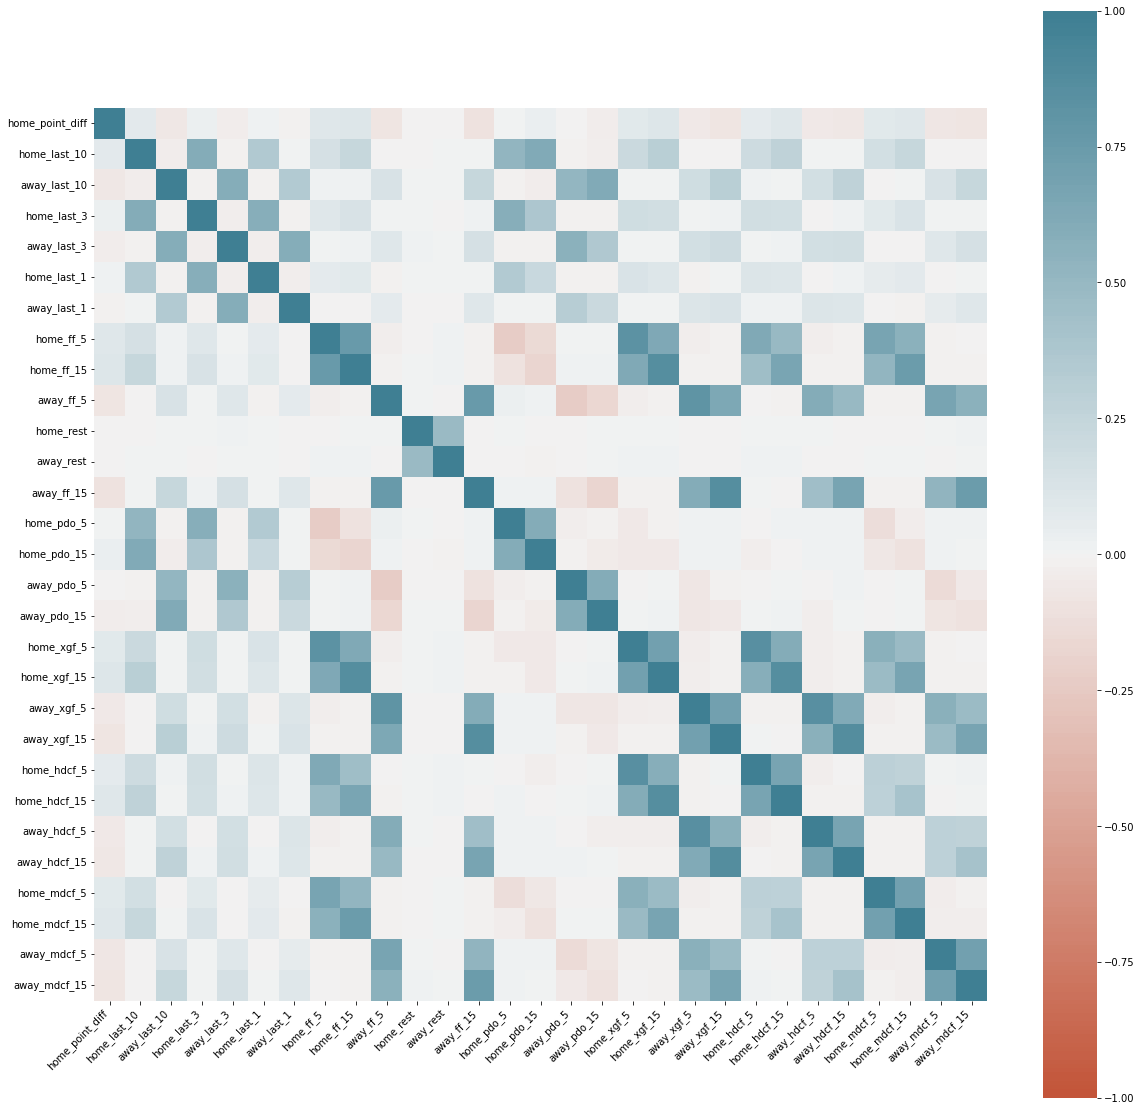

In [39]:
# Correlation
corr = train_data_no_leak.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [40]:
# Regressor

train_data = train_data_no_leak.drop(['home_point_diff'], axis=1)
target_label = train_data_no_leak['home_point_diff']

n_features = train_data.shape[1]
x_train, x_test, y_train, y_test = train_test_split(train_data, target_label, test_size = 0.30)

clf = ensemble.GradientBoostingRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 15, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print(clf_gp.fun)
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (clf_gp.x[0], clf_gp.x[1],
                            clf_gp.x[2], clf_gp.x[3],
                            clf_gp.x[4]))

1.954471441217897
Best parameters:
- max_depth=10
- learning_rate=0.057055
- max_features=28
- min_samples_split=13
- min_samples_leaf=65


In [41]:
clf.fit(x_train, y_train)

perm = PermutationImportance(clf).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.0036 ± 0.0022,away_last_10
0.0035 ± 0.0005,away_rest
0.0031 ± 0.0020,home_mdcf_15
0.0025 ± 0.0023,away_ff_5
0.0019 ± 0.0025,home_ff_15
0.0013 ± 0.0023,away_mdcf_5
0.0011 ± 0.0013,home_hdcf_15
0.0010 ± 0.0017,away_pdo_15
0.0010 ± 0.0026,home_pdo_15
0.0007 ± 0.0013,away_mdcf_15


In [47]:
full_y_pred = clf.predict(all_data_no_leak.drop(['home_point_diff'], axis=1))

combined_df_aux["predicted_diff"] = full_y_pred

combined_df_aux


,Date_x,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,OpenOOdds,...,away_xgf_15,home_hdcf_5,home_hdcf_15,away_hdcf_5,away_hdcf_15,home_mdcf_5,home_mdcf_15,away_mdcf_5,away_mdcf_15,predicted_diff
0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,100,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.034055
1,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,-115,...,-0.062667,1.2,0.400000,-1.2,-0.400000,0.4,0.133333,-0.4,-0.133333,0.908556
2,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,105,...,0.084667,0.0,0.000000,2.4,0.800000,0.0,0.000000,-0.2,-0.066667,0.065577
3,1003,Montreal,1,0,1,3,130.0,140.0,6.0,-105,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.034055
4,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,-120,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.034055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16263,514,Toronto,1,1,0,2,-165.0,-152.0,6.0,-110,...,0.506667,1.2,-0.800000,3.0,3.400000,3.6,1.400000,1.4,1.200000,-0.043088
16264,515,Vancouver,0,1,3,4,180.0,165.0,6.0,-110,...,-0.676000,-0.2,-0.133333,-1.8,-2.666667,-0.4,-1.800000,-6.4,-6.600000,1.654707
16265,516,Calgary,1,4,0,6,-130.0,-139.0,5.5,-115,...,0.470000,-2.4,-2.400000,2.0,2.466667,-4.2,-5.333333,6.2,2.866667,-0.971428
16266,518,Calgary,0,0,2,2,-135.0,-110.0,6.0,105,...,0.530667,-3.4,-2.533333,2.2,2.866667,-2.2,-5.066667,5.4,2.800000,-0.726009


10081
4322
1606
0


Text(0, 0.5, 'Bankroll')

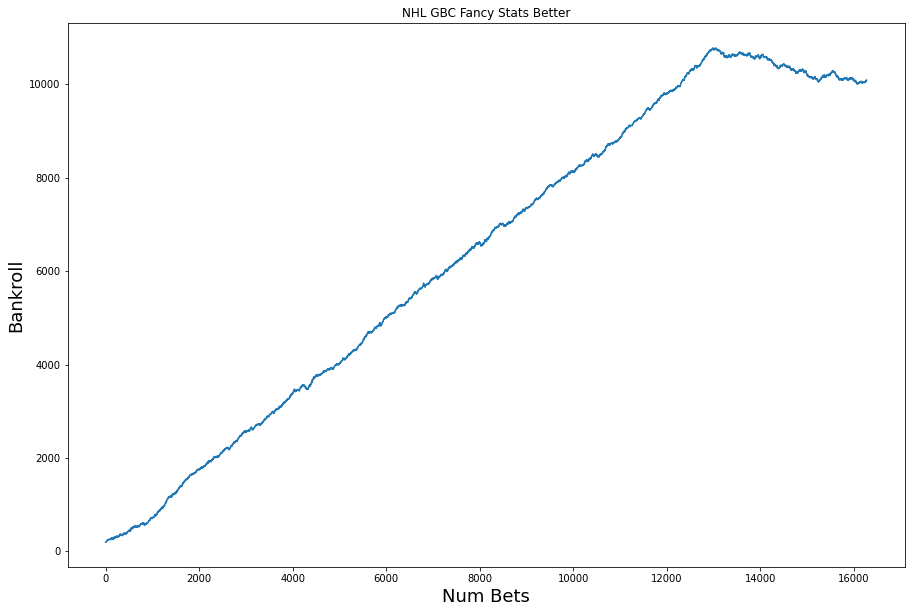

In [64]:
# Backtester

def calculate_profit(odds, wager):
    # -101 and beyond
    if(odds < 0):
        return int((100 / abs(odds)) * wager)
    # +100 and beyond
    return int((odds / 100) * wager)


money = 200
money_graph = []
won = 0
loss = 0
push = 0


for row in combined_df_aux.itertuples():

    # bet on away team if we think that they'll win by 0.5
    if row.predicted_diff < -0.5:
        if row.away_point_diff > 0:
            money += calculate_profit(row.MlAwayClose, 10)
            won += 1
        else:
            money -= 10
            loss += 1

    # bet on home team if we think that they'll win by 0.5
    if row.predicted_diff > 0.5:
        if row.home_point_diff > 0:
            money += calculate_profit(row.MlHomeClose, 10)
            won += 1
        else:
            money -= 10
            loss += 1

    money_graph.append(money)

    if money <= 0:
        print ("BUST!")
        break



print (money)
print (won)
print (loss)
print (push)

plt.plot(money_graph) 
plt.rcParams["figure.figsize"] = (15,10)
plt.title('NHL GBC Fancy Stats Better')
plt.xlabel('Num Bets', fontsize=18)
plt.ylabel('Bankroll', fontsize=18)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f0efbe77-01fa-4860-b5ee-e7eac30d44e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>